In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
import seaborn as sns
from matplotlib import pyplot as plt

from open_pref_eval.evaluation import evaluate, evaluate_model

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

In [3]:
N = 300
model_name = "gepardzik/LLama-3-8b-rogue-lora"

In [4]:
imdb = load_dataset('wassname/imdb_dpo', split=f'test[:{N}]', keep_in_memory=False)
imdb

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 200
})

In [5]:
df_agg, df_raw = evaluate_model(
    model_name=model_name, datasets=[imdb],
    per_device_eval_batch_size=3,
    calibrate=False,
    bf16=True,
    )
df_agg

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Parameter 'function'=<bound method DPOTrainer.tokenize_row of <open_pref_eval.trainer.OPETrainer object at 0x70c821ba5810>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Eval imdb_dpo default train:   0%|          | 0/34 [00:00<?, ?it/s]

,prob,correct,n
dataset,,,
imdb_dpo default train,0.764003,0.845,200


In [ ]:
# 1/0

In [ ]:
# def calibrate_prob(df: pd.DataFrame, N:Union[bool,int]=False) -> pd.DataFrame:
#     if N is False:
#         N = 50
    
#     df_train = df.iloc[:N].copy()
#     df_test = df.iloc[N:].copy()
#     calib = 
#     calib = get_calibrator(df_train['prob'].values)
#     df_test['prob_calib'] = calib.predict(df_test['prob'].values)
    
#     # prevent data leakage
#     df_train['prob_calib'] = np.nan
#     df = pd.concat([df_train, df_test])
#     return df

In [ ]:
# calibrator = LogisticRegression(penalty="none").fit(scores, labels)
# calibrated_probs = calibrator.predict_proba(scores)[:, 1]
# print("Brier Score before Calibration:", brier_score_loss(labels, scores))
# print("Brier Score after Calibration:", brier_score_loss(labels, calibrated_probs))

## Manually calib

In [14]:
# from open_pref_eval.evaluation import calibrate_prob
# df_raw2 = calibrate_prob(df_raw, N=20)
# # df_raw2

df_raw2 = df_raw.copy()

In [67]:
# calibration_curve
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_calib(df_raw2):
    y_prob = df_raw2['prob'].dropna().values
    y_true = np.ones_like(y_prob)

    # flip half
    flip = np.random.choice([0, 1], size=len(y_true))==1
    y_true[flip] = 1 - y_true[flip]
    y_prob[flip] = 1 - y_prob[flip]

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label='uncalib')

    y_prob = df_raw2['prob_calib'].dropna().values
    y_true = np.ones_like(y_prob)

    # # flip half
    # # flip = np.random.choice([0, 1], size=len(y_true))==1
    y_true[flip] = 1 - y_true[flip]
    y_prob[flip] = 1 - y_prob[flip]

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='.', label='calibrated', alpha=0.5)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='perfectly calibrated')
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')

    plt.legend()

    df_raw2['correct2'] = df_raw2['prob_calib']>0.5
    df_agg =  df_raw2.groupby(['dataset'], dropna=False)[['correct', 'correct2', 'prob', 'prob_calib']].mean()
    display(df_agg)

,correct,correct2,prob,prob_calib
dataset,,,,
imdb_dpo default train,0.845,0.845,0.764003,0.762881


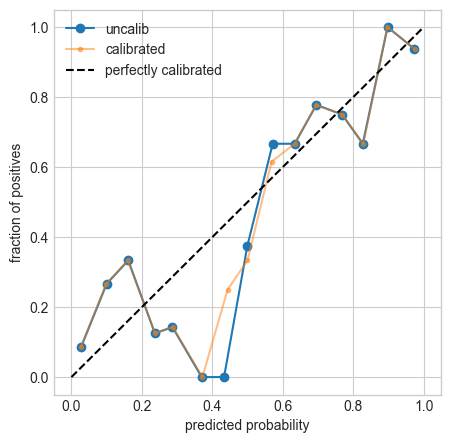

In [68]:
# Simple scaling function
def scale_probs(probs, new_min=0., new_max=1.0):
    return (probs - probs.min()) / (probs.max() - probs.min()) * (new_max - new_min) + new_min

df_raw2['prob_calib'] = scale_probs(df_raw2['prob'])
df_raw2['prob_calib'].describe()

plot_calib(df_raw2)

In [69]:
N

200

,correct,correct2,prob,prob_calib
dataset,,,,
imdb_dpo default train,0.845,0.795,0.764003,0.629455


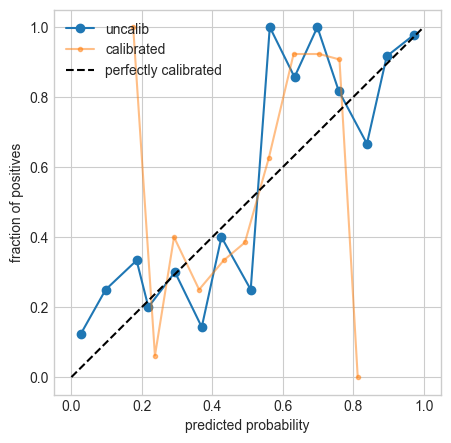

In [70]:
df_raw2 = df_raw.copy()

y_prob = df_raw2['prob'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
flip = np.random.choice([0, 1], size=len(y_true))==1
y_true[flip] = 1 - y_true[flip]
y_prob[flip] = 1 - y_prob[flip]

R = N//3
X = y_prob[:R]
y = y_true[:R]

from sklearn.linear_model import LogisticRegression
clr = LogisticRegression().fit(X.reshape(-1, 1), y)

df_raw2['prob_calib'] = clr.predict_proba(df_raw2['prob'].values.reshape(-1, 1))[:, 1]

df_raw2['correct2'] = df_raw2['prob_calib']>0.5

plot_calib(df_raw2)

,correct,correct2,prob,prob_calib
dataset,,,,
imdb_dpo default train,0.845,0.84,0.764003,0.790574


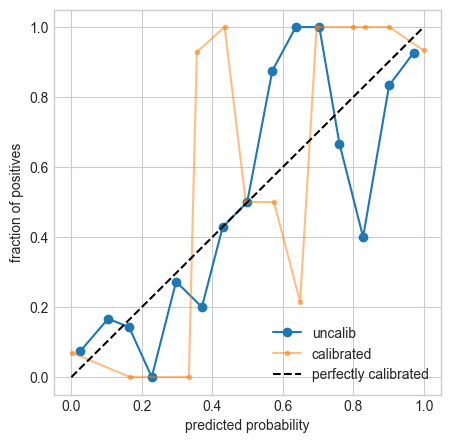

In [71]:
df_raw2 = df_raw.copy()

y_prob = df_raw2['prob'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
flip = np.random.choice([0, 1], size=len(y_true))==1
y_true[flip] = 1 - y_true[flip]
y_prob[flip] = 1 - y_prob[flip]

X = y_prob[:R]
y = y_true[:R]

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import _SigmoidCalibration
from sklearn.linear_model import LogisticRegression
clr = IsotonicRegression(out_of_bounds="clip", increasing=True).fit(X, y)
# clr = LogisticRegression().fit(X.reshape(-1, 1), y)

df_raw2['prob_calib'] = clr.predict(df_raw2['prob'].values.reshape(-1, 1))

plot_calib(df_raw2)

,correct,correct2,prob,prob_calib
dataset,,,,
imdb_dpo default train,0.845,0.79,0.764003,0.681357


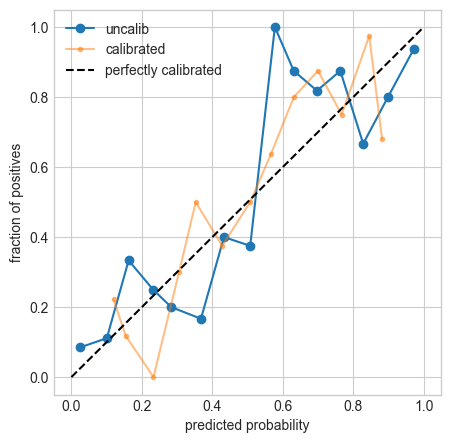

In [72]:
df_raw2 = df_raw.copy()

y_prob = df_raw2['prob'].dropna().values
y_true = np.ones_like(y_prob)

# flip half
flip = np.random.choice([0, 1], size=len(y_true))==1
y_true[flip] = 1 - y_true[flip]
y_prob[flip] = 1 - y_prob[flip]

X = y_prob[:R]
y = y_true[:R]

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import _SigmoidCalibration
from sklearn.linear_model import LogisticRegression
clr = _SigmoidCalibration().fit(X, y)
# clr = LogisticRegression().fit(X.reshape(-1, 1), y)

df_raw2['prob_calib'] = clr.predict(df_raw2['prob'].values.reshape(-1, 1))

plot_calib(df_raw2)

In [73]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.calibration import calibration_curve
# from sklearn.isotonic import IsotonicRegression

# # Generate sample data
# np.random.seed(42)
# n_samples = 1000

# # Generate probabilities between 0 and 1
# # Using beta distribution to simulate a more realistic probability distribution
# probabilities = np.random.beta(2, 5, n_samples)

# # All labels are 1
# labels = np.ones(n_samples)

# # Function to plot reliability curve
# def plot_reliability_curve(y_true, y_prob, n_bins=10, ax=None):
#     if ax is None:
#         fig, ax = plt.subplots()
    
#     fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=n_bins)
    
#     ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
#     ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
#     ax.set_xlabel("Mean predicted probability")
#     ax.set_ylabel("Fraction of positives")
#     ax.set_title("Reliability Curve")
#     ax.legend(loc="lower right")
#     return ax

# # Plot original reliability curve
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot_reliability_curve(labels, probabilities, ax=ax1)
# ax1.set_title("Original Reliability Curve")

# # Apply isotonic regression for calibration
# ir = IsotonicRegression(out_of_bounds="clip")
# calibrated_probs = ir.fit_transform(probabilities, labels)

# # Plot calibrated reliability curve
# plot_reliability_curve(labels, calibrated_probs, ax=ax2)
# ax2.set_title("Calibrated Reliability Curve")

# plt.tight_layout()
# plt.show()

# # Print some sample probabilities
# print("Sample original probabilities:")
# print(probabilities[:10])
# print("\nSample calibrated probabilities:")
# print(calibrated_probs[:10])

# # Calculate mean probabilities
# print(f"\nMean original probability: {np.mean(probabilities):.3f}")
# print(f"Mean calibrated probability: {np.mean(calibrated_probs):.3f}")